In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, and_, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [101]:
#Get header information for tables
print(Measurement.__table__.columns.keys())
print(Station.__table__.columns.keys())

#Get the final date of the data set
last = session.query(Measurement.date).filter(Measurement.date == session.query(func.max(Measurement.date))).all()
print(last)

['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']
[('2017-08-23',), ('2017-08-23',), ('2017-08-23',), ('2017-08-23',)]


In [102]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').order_by(Measurement.date).all()

In [12]:
#assign data to a dataframe
precip = pd.DataFrame(precip)


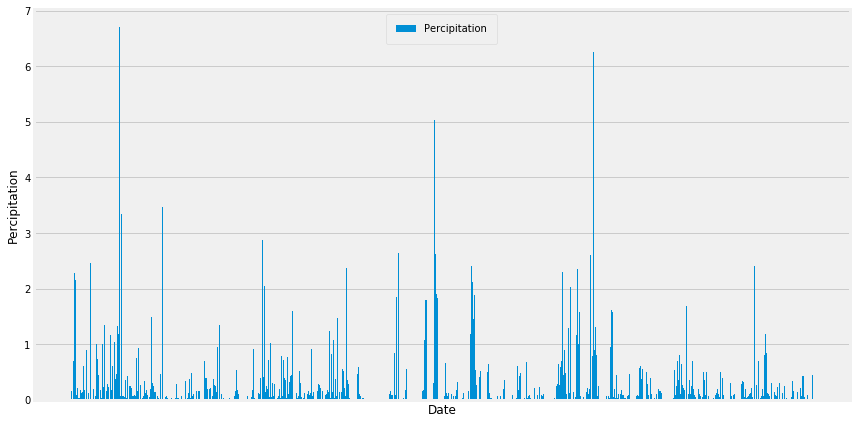

In [39]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(precip.index,precip['prcp'],width=2)
ax.set_xticks([], [])
ax.get_xaxis().get_major_formatter()
ax.set_xlabel("Date")
ax.set_ylabel("Percipitation")
ax.legend(["Percipitation"],loc='upper center', borderpad=1)
fig.tight_layout()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct(Measurement.station).count()
print(stations)

9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations = pd.DataFrame(active_stations, columns =['Station', 'Station Entry Count']) 
active_stations

,Station,Station Entry Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [40]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = active_stations["Station"].iloc[0]

temps = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).order_by(func.count(Measurement.station).desc()).all()
temps = pd.DataFrame(temps, columns =['Station', 'Min Temp', 'Max Temp', 'Avg Temp']) 
temps

,Station,Min Temp,Max Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


In [78]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temps = pd.read_sql(session.query(Measurement).order_by(Measurement.date).filter(Measurement.station == most_active).filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').statement, engine)
most_temps.head()

,id,station,date,prcp,tobs
0,14608,USC00519281,2016-08-23,1.79,77.0
1,14609,USC00519281,2016-08-24,2.15,77.0
2,14610,USC00519281,2016-08-25,0.06,80.0
3,14611,USC00519281,2016-08-26,0.01,80.0
4,14612,USC00519281,2016-08-27,0.12,75.0


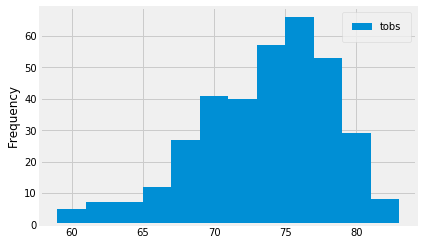

In [80]:
#Histogram of the dataframe
fig, ax = plt.subplots()
ax.hist(most_temps['tobs'],12)
ax.set_ylabel("Frequency")
ax.legend(["tobs"],loc='best', borderpad=1)
plt.show()

In [81]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [200]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-05-01', '2017-05-07'))
my_trip = pd.DataFrame(calc_temps('2017-05-01', '2017-05-07'), columns = ['Min Temp', 'Max Temp', 'Avg Temp'])
yerr = my_trip['Max Temp'] - my_trip['Min Temp']

[(65.0, 75.675, 80.0)]


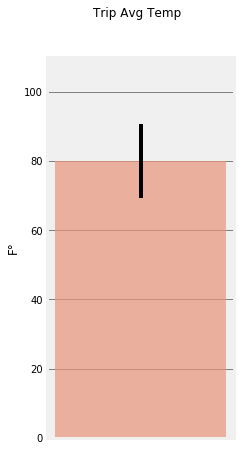

In [201]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,7))
ax.bar(1,my_trip['Avg Temp'], yerr=yerr,color='darksalmon', alpha=.7)
ax.set_xticks([], [])
ax.grid(color='gray', linestyle='-', linewidth=1,)
ax.set_ylim(0,110)
ax.set_ylabel("F°")
fig.suptitle("Trip Avg Temp")
plt.show()

In [209]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_precip = session.query(Measurement.station, func.sum(Measurement.prcp).label("prcp"), Station.name, Station.latitude, Station.longitude, Station.elevation)\
                            .filter(Measurement.station == Station.station)\
                            .group_by(Measurement.station)\
                            .filter(Measurement.date >= '2017-05-01').filter(Measurement.date <= '2017-05-07').all()
trip_precip = pd.DataFrame(trip_precip)
trip_precip = trip_precip.fillna(0).sort_values('prcp', ascending=False)
trip_precip.head(9)



,station,prcp,name,latitude,longitude,elevation
1,USC00514830,0.47,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00516128,0.38,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00519397,0.26,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
0,USC00513117,0.18,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519281,0.17,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
5,USC00519523,0.07,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
